In [ ]:
import tensorflow
print(tensorflow.__version__)
import keras
print(keras.__version__)

1.5.0
2.1.5


Using TensorFlow backend.


In [ ]:
# Import required libraries
import os
import gc
import sys
import json
import random
from pathlib import Path

import cv2
import numpy as np 
import pandas as pd

import seaborn as sns
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import glob

import warnings 
warnings.filterwarnings("ignore")

## EDA

In [ ]:
%%time
with open('label_descriptions.json', 'r') as file:
    label_desc = json.load(file)
data_df = pd.read_csv('train.csv')

CPU times: user 10.9 s, sys: 1.05 s, total: 12 s
Wall time: 12 s


In [ ]:
data_df.head()

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds
0,00000663ed1ff0c4e0132b9b9ac53f6e,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,"115,136,143,154,230,295,316,317"
1,00000663ed1ff0c4e0132b9b9ac53f6e,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,"115,136,142,146,225,295,316,317"
2,00000663ed1ff0c4e0132b9b9ac53f6e,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,163
3,00000663ed1ff0c4e0132b9b9ac53f6e,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,"160,204"
4,00000663ed1ff0c4e0132b9b9ac53f6e,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,219


In [ ]:
print(f'Shape of training dataset: {data_df.shape}')

Shape of training dataset: (333401, 6)


In [ ]:
data_df.dtypes

ImageId          object
EncodedPixels    object
Height            int64
Width             int64
ClassId           int64
AttributesIds    object
dtype: object

In [ ]:
data_df[['ImageId', 'EncodedPixels', 'Height', 'Width', 'ClassId']].isna().sum()

ImageId          0
EncodedPixels    0
Height           0
Width            0
ClassId          0
dtype: int64

In [ ]:
print(f'Segments that do not have attributes: {data_df["AttributesIds"].isna().sum()/len(data_df) * 100} %')

Segments that do not have attributes: 38.089567817733 %


In [ ]:
print(f'# of images in dataset: {data_df["ImageId"].nunique()}')

# of images in dataset: 45623


In [ ]:
pd.DataFrame([data_df['Height'].describe(), data_df['Width'].describe()]).T.loc[['max', 'min', 'mean']]

,Height,Width
max,8688.000000,10717.00000
min,296.000000,151.00000
mean,2235.524021,1761.97925


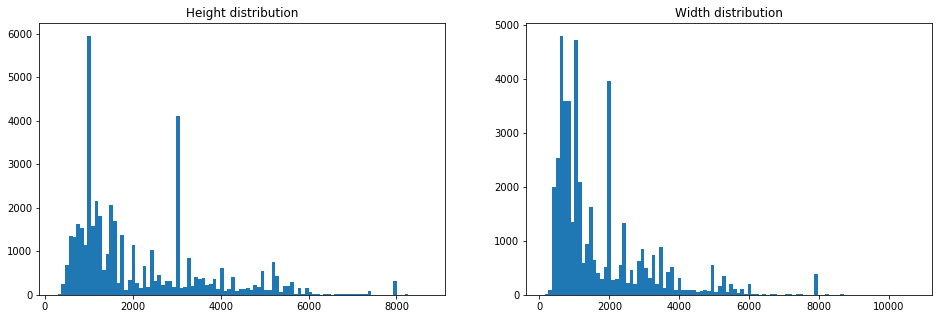

In [ ]:
image_shape_df = data_df.groupby("ImageId")[["Height", "Width"]].first()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
ax1.hist(image_shape_df['Height'], bins=100)
ax1.set_title("Height distribution")
ax2.hist(image_shape_df['Width'], bins=100)
ax2.set_title("Width distribution")
plt.show()

In [ ]:
category_map = {}
for cat in label_desc.get('categories'):
    category_map[cat.get('id')] = cat.get('name')

In [ ]:
data_df['Category'] = data_df['ClassId'].map(category_map)

In [ ]:
data_df.head()

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds,Category
0,00000663ed1ff0c4e0132b9b9ac53f6e,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,"115,136,143,154,230,295,316,317",pants
1,00000663ed1ff0c4e0132b9b9ac53f6e,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,"115,136,142,146,225,295,316,317","shirt, blouse"
2,00000663ed1ff0c4e0132b9b9ac53f6e,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,163,collar
3,00000663ed1ff0c4e0132b9b9ac53f6e,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,"160,204",sleeve
4,00000663ed1ff0c4e0132b9b9ac53f6e,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,219,pocket


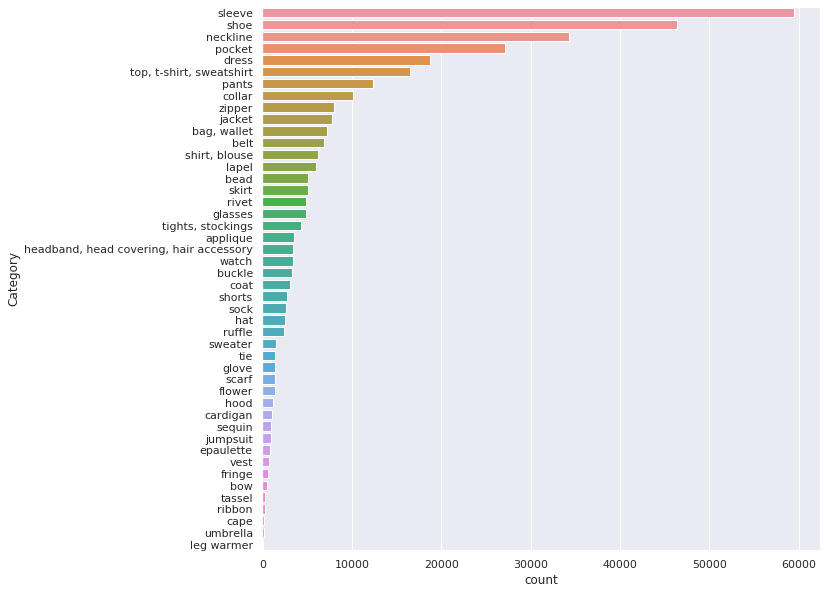

In [ ]:
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize = (10,10))
sns.countplot(y='Category', data=data_df, ax=ax, order=data_df['Category'].value_counts().index)
fig.show()

In [ ]:
plt.figure(figsize = (10,10))
min_height = list(set(data_df[data_df['Height'] == data_df['Height'].min()]['ImageId']))[0]
plt.imshow(mpimg.imread(f'train/{min_height}.jpg'))
plt.grid(False)
plt.show()

In [ ]:
plt.figure(figsize = (10,10))
max_height = list(set(data_df[data_df['Height'] == data_df['Height'].max()]['ImageId']))[0]
plt.imshow(mpimg.imread(f'train/{max_height}.jpg'))
plt.grid(False)
plt.show()

In [ ]:
plt.figure(figsize = (10,10))
min_width = list(set(data_df[data_df['Width'] == data_df['Width'].min()]['ImageId']))[0]
plt.imshow(mpimg.imread(f'train/{min_width}.jpg'))
plt.grid(False)
plt.show()

In [ ]:
plt.figure(figsize = (10,10))
max_width = list(set(data_df[data_df['Width'] == data_df['Width'].max()]['ImageId']))[0]
plt.imshow(mpimg.imread(f'train/{max_width}.jpg'))
plt.grid(False)
plt.show()

In [ ]:
area_df = pd.DataFrame()
area_df['ImageId'] = data_df['ImageId']
area_df['area'] = data_df['Height'] * data_df['Width']
min_area = list(set(area_df[area_df['area'] == area_df['area'].min()]['ImageId']))[0]
max_area = list(set(area_df[area_df['area'] == area_df['area'].max()]['ImageId']))[0]

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(mpimg.imread(f'train/{min_area}.jpg'))
plt.grid(False)
plt.show()

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(mpimg.imread(f'train/{max_area}.jpg'))
plt.grid(False)
plt.show()

In [ ]:
NUM_CLASSES = len(label_desc['categories'])
print(f'Total # of classes: {NUM_CLASSES}')

Total # of classes: 46


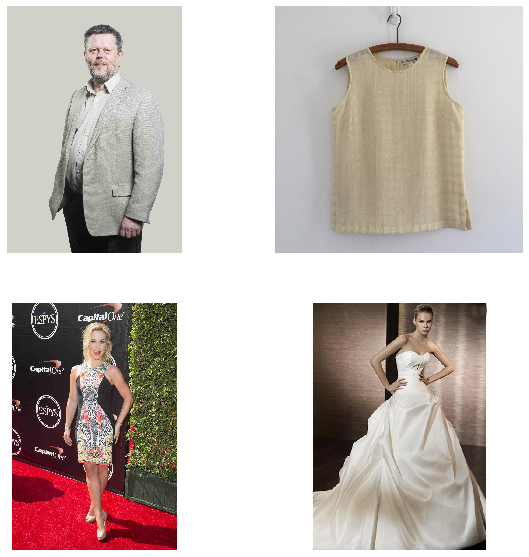

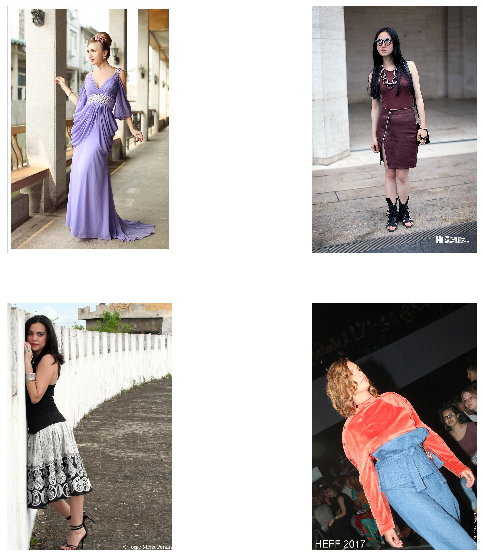

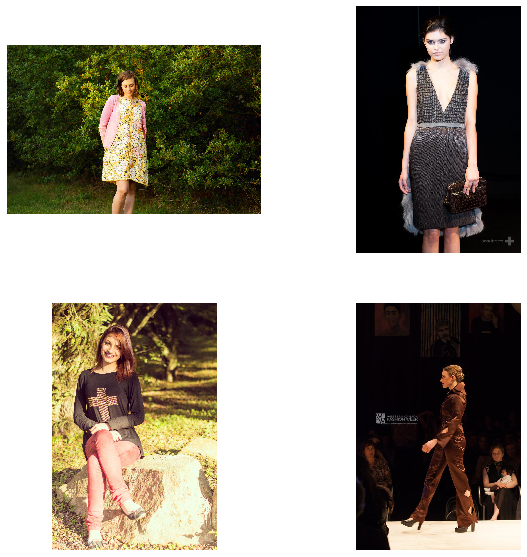

In [ ]:
# First get some images to be plotted
def plot_images(size=12, figsize=(10, 10)):
    image_ids = data_df['ImageId'].unique()[:12]
    images=[]
    
    for image in image_ids:
        images.append(mpimg.imread(f'train/{image}.jpg'))
    count = 0
    for index in range(size // 4):
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=figsize)
        for row in ax:
            for col in row:
                col.imshow(images[count])
                col.axis('off')
                count += 1
        plt.show()
    gc.collect()

plot_images()

In [ ]:
def create_mask(size):
    image_ids = data_df['ImageId'].unique()[:size]
    images_meta=[]

    for image_id in image_ids:
        img = mpimg.imread(f'train/{image_id}.jpg')
        images_meta.append({
            'image': img,
            'shape': img.shape,
            'encoded_pixels': data_df[data_df['ImageId'] == image_id]['EncodedPixels'],
            'class_ids':  data_df[data_df['ImageId'] == image_id]['ClassId']
        })

    masks = []
    for image in images_meta:
        shape = image.get('shape')
        encoded_pixels = list(image.get('encoded_pixels'))
        class_ids = list(image.get('class_ids'))
        
        # Initialize numpy array with shape same as image size
        height, width = shape[:2]
        mask = np.zeros((height, width)).reshape(-1)
        
        # Iterate over encoded pixels and create mask
        for segment, (pixel_str, class_id) in enumerate(zip(encoded_pixels, class_ids)):
            splitted_pixels = list(map(int, pixel_str.split()))
            pixel_starts = splitted_pixels[::2]
            run_lengths = splitted_pixels[1::2]
            assert max(pixel_starts) < mask.shape[0]
            for pixel_start, run_length in zip(pixel_starts, run_lengths):
                pixel_start = int(pixel_start) - 1
                run_length = int(run_length)
                mask[pixel_start:pixel_start+run_length] = 255 - int(class_id) * 4
        masks.append(mask.reshape((height, width), order='F'))
    return masks, images_meta

In [ ]:
def plot_segmented_images(size=12, figsize=(10, 10)):
    # First create masks from given segments
    masks, images_meta = create_mask(size)
    
    count = 0
    for index in range(size // 4):
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=figsize)
        for row in ax:
            for col in row:
                col.imshow(images_meta[count]['image'])
                col.imshow(masks[count], alpha=0.75)
                col.axis('off')
                count += 1
        plt.show()
    gc.collect()

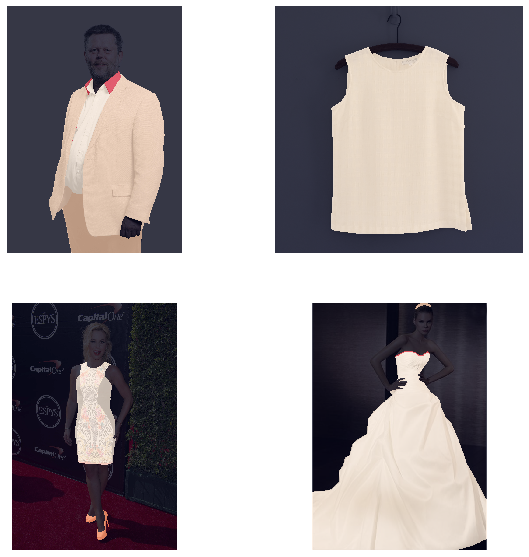

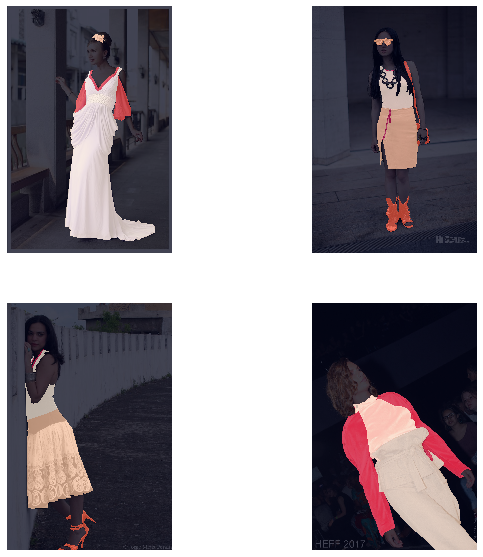

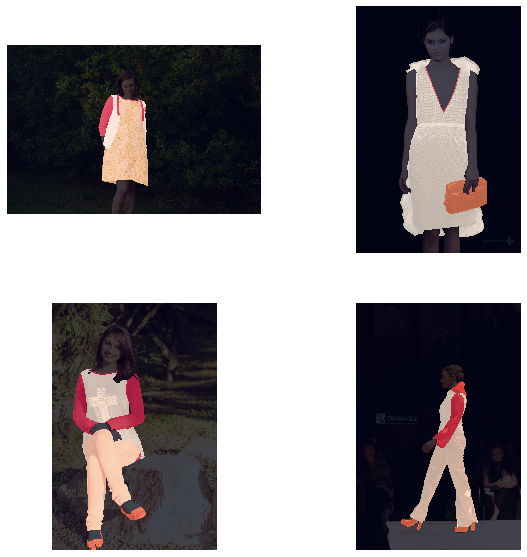

In [ ]:
plot_segmented_images()

## Train, Validation, and Test datasets

In [ ]:
images_df = data_df.groupby('ImageId')[['EncodedPixels', 'ClassId']].agg(lambda x: list(x))
size_df = data_df.groupby('ImageId')[['Height', 'Width']].first()
images_df = images_df.join(size_df, on='ImageId')

print("Total images: ", len(images_df))
images_df.head()

Total images:  45623


,EncodedPixels,ClassId,Height,Width
ImageId,,,,
00000663ed1ff0c4e0132b9b9ac53f6e,[6068157 7 6073371 20 6078584 34 6083797 48 60...,"[6, 0, 28, 31, 32, 32, 31, 29, 4]",5214,3676
0000fe7c9191fba733c8a69cfaf962b7,[2201176 1 2203623 3 2206071 5 2208518 8 22109...,"[33, 1]",2448,2448
0002ec21ddb8477e98b2cbb87ea2e269,[2673735 2 2676734 8 2679734 13 2682733 19 268...,"[33, 10, 23, 23]",3000,1997
0002f5a0ebc162ecfb73e2c91e3b8f62,[435 132 1002 132 1569 132 2136 132 2703 132 3...,"[10, 33, 15]",567,400
0004467156e47b0eb6de4aa6479cbd15,[132663 8 133396 25 134130 41 134868 53 135611...,"[10, 33, 31, 31, 15]",750,500


In [ ]:
train_limit = int(len(images_df)*.70)
val_limit = int(len(images_df)*.20)
train_limit, val_limit

(31936, 9124)

In [ ]:
df_train = images_df[:train_limit]
df_val = images_df[train_limit:train_limit+val_limit]
df_test = images_df[train_limit+val_limit:]

df_train.shape, df_val.shape, df_test.shape

((31936, 4), (9124, 4), (4563, 4))

## Configurations

In [ ]:
!git clone https://github.com/matterport/Mask_RCNN
%cd Mask_RCNN
!pip3 install -r requirements.txt
!python3 setup.py install

In [ ]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [ ]:
class FashionConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "image_segmentation"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + NUM_CLASSES  # background + 46 classes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = FashionConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [ ]:
DATA_DIR = '../train'

In [ ]:
class FashionDataset(utils.Dataset):
    def __init__(self, df):
        super().__init__(self)
        
        self.IMAGE_SIZE = 256
        
        # Add classes
        for cat in label_desc['categories']:
            self.add_class('dataset', cat.get('id'), cat.get('name'))
        
        # Add images
        for i, row in df.iterrows():
            self.add_image('dataset', 
                           image_id=row.name, 
                           path=os.path.join(DATA_DIR, row.name + '.jpg'), 
                           labels=row['ClassId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], 
                           width=row['Width'])
            
    def resize_image(self, image_path):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.IMAGE_SIZE, self.IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
        return img
        
    def load_image(self, image_id):
        return self.resize_image(self.image_info[image_id]['path'])
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [x for x in info['labels']]
    
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # masks: A bool array of shape [height, width, instance count] with one mask per instance.     
        mask = np.zeros((self.IMAGE_SIZE, self.IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (self.IMAGE_SIZE, self.IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

In [ ]:
# Create training, validation, and test set
# train set
dataset_train = FashionDataset(df_train)
dataset_train.prepare()
print('Train: %d' % len(dataset_train.image_ids))
 
# validation set
dataset_val = FashionDataset(df_val)
dataset_val.prepare()
print('Validation: %d' % len(dataset_val.image_ids))

# test set
dataset_test = FashionDataset(df_test)
dataset_test.prepare()
print('Test: %d' % len(dataset_test.image_ids))

Train: 31936
Validation: 9124
Test: 4563


In [ ]:
# Load and display random samples
def visualize_image_mask(dataset, num_imgs=5, limit=5):
    for i in range(num_imgs):
        image_id = random.choice(dataset.image_ids)

        image = dataset.load_image(image_id)
        mask, class_ids = dataset.load_mask(image_id)
        visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=limit)

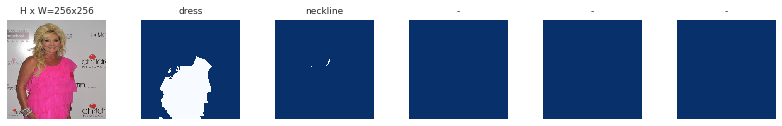

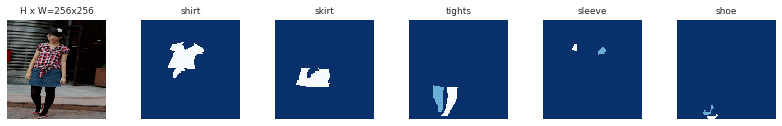

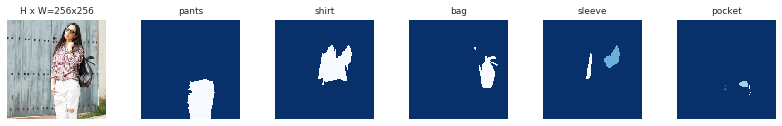

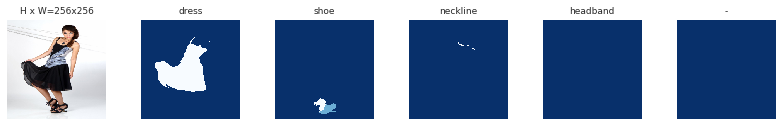

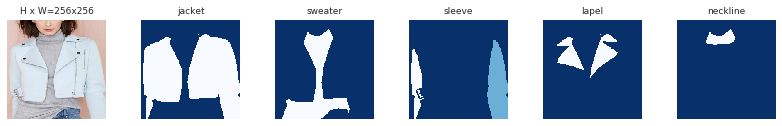

In [ ]:
visualize_image_mask(dataset_train)

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

In [ ]:
# model = load_model_weights(model)
# Exclude the last layers because they require a matching number of classes
model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
EPOCHS = 6

callbacks = [
    EarlyStopping(patience=3, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1)
]

In [ ]:
%%time
# Passing layers="heads" freezes all layers except the head layers. 
model.train(dataset_train, dataset_val,
                    learning_rate=config.LEARNING_RATE,
                    epochs=EPOCHS,
                    layers='heads',
                    custom_callbacks = callbacks,
                    augmentation = None)

history = model.keras_model.history.history


# Passing layers="all" trains all layers.
# model.train(dataset_train, dataset_val, 
#             learning_rate=config.LEARNING_RATE,
#             epochs=EPOCHS, 
#             layers="all")


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/ec2-user/SageMaker/logs/image_segmentation20210221T0047/mask_rcnn_image_segmentation_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (

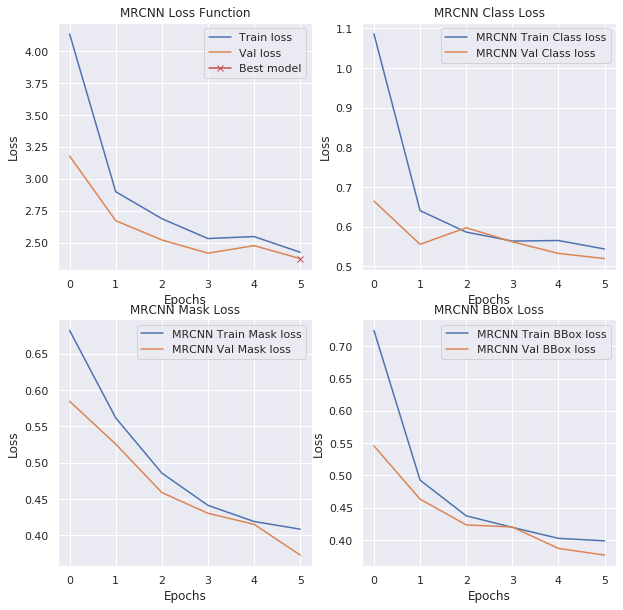

In [ ]:
# plot loss
plt.figure(figsize=(10,10))

plt.subplot(221),plt.plot(history["loss"], label='Train loss'),
plt.plot(history["val_loss"], label='Val loss')
plt.plot(np.argmin(history["val_loss"]), np.min(history["val_loss"]), marker='x', color='r', label='Best model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('MRCNN Loss Function')

plt.subplot(222),
plt.plot(history["mrcnn_class_loss"], label='MRCNN Train Class loss'),
plt.plot(history["val_mrcnn_class_loss"], label='MRCNN Val Class loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('MRCNN Class Loss')

plt.subplot(223),
plt.plot(history["mrcnn_mask_loss"], label='MRCNN Train Mask loss'),
plt.plot(history["val_mrcnn_mask_loss"], label='MRCNN Val Mask loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('MRCNN Mask Loss')

plt.subplot(224),
plt.plot(history["mrcnn_bbox_loss"], label='MRCNN Train BBox loss'),
plt.plot(history["val_mrcnn_bbox_loss"], label='MRCNN Val BBox loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('MRCNN BBox Loss')

plt.show()

In [ ]:
best_epoch = np.argmin(history["val_loss"]) + 1
print("Best epoch: ", best_epoch)
print("Valid loss: ", history["val_loss"][best_epoch-1])

In [ ]:
glob_list = glob.glob(f'../logs/image_*/mask_rcnn_image_segmentation_{best_epoch:04d}.h5')
model_path = glob_list[0] if glob_list else ''

In [ ]:
class InferenceConfig(FashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

assert model_path != '', "Provide path to trained weights"
print("Loading weights ...")
model.load_weights(model_path, by_name=True)
print("Done!")

Loading weights ...
Re-starting from epoch 6
Done!


In [ ]:
def get_ax(rows=1, cols=1, size=8):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [ ]:
# Display single image with detections and boxes
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax(1))

In [ ]:
# Display single image with detections and boxes and ground truths
image_id = random.choice(dataset_test.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, config, image_id, use_mini_mask=False)
info = dataset_test.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_test.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset_test.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.5, score_threshold=0.5)

In [ ]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

In [ ]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset_val.class_names)

In [ ]:
# Compute mAP @ IoU=50, IoU=0.75 and IoU=[0.5-0.95] on Batch of Images
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    AP50s = []
    AP75s = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        
        # Compute AP @ IoU = 50
        ap50, precisions, recalls, overlaps= utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'],
                            iou_threshold=0.5)
        AP50s.append(ap50)
        # Compute AP @ IoU = 75
        ap75, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'],
                            iou_threshold=0.75)
        AP75s.append(ap75)
        
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("ID: {:3} W,H,C:{}, AP: {:.2f}, AP.50: {:.2f},AP.75: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap, ap50, ap75))
    return APs, AP50s, AP75s

# Run on 100 random images
limit = 100
APs, AP50s, AP75s = compute_batch_ap(dataset_test, dataset_test.image_ids[:limit], verbose = 0)
print("mAP @ IoU=50 for {} images: {}".format(limit, np.mean(AP50s)))
print("mAP @ IoU=75 for {} images: {}".format(limit, np.mean(AP75s)))
print("mAP @ IoU=[0.5..0.95] for {} images: {}".format(limit, np.mean(APs)))

In [ ]:
import matplotlib.pyplot as plt
plt.plot(APs)
plt.ylabel('AP')
plt.show()